In [209]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
import pymc3 as pm
import theano as thno
import theano.tensor as T

from scipy import integrate
from scipy.optimize import fmin_powell
import arviz as az
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelBinarizer
import arviz as az
%matplotlib inline

In [210]:
tox21_two_assays = pd.read_csv("two-assay-example.csv")

## Single assay example with 3 features

In [211]:
one_assay = tox21_two_assays[tox21_two_assays['PROTOCOL_NAME'] == 'tox21-ar-mda-kb2-luc-agonist-p3']

In [212]:
X = one_assay.iloc[:,3:]
y = one_assay.CHANNEL_OUTCOME

In [213]:
X_bayes = one_assay[['FpDensityMorgan2', 'BCUT2D_LOGPLOW','FractionCSP3']]
X_bayes.insert(0,'Intercept',1)
Y_bayes = pd.factorize(one_assay.CHANNEL_OUTCOME)

In [215]:
with pm.Model() as logistic_model:
    betas = pm.Normal('betas', 0.0, sd=3.0, shape=4)
    p = 1.0 / (1.0 + T.exp(-T.dot(X_bayes, betas)))
    likelihood = pm.Bernoulli('likelihood', p, observed=Y_bayes[0])


In [ ]:
with logistic_model:
    tr = pm.sample(500, tune=500, init="adapt_diag",chains=4,cores=8)

In [ ]:
with logistic_model:
    az.plot_trace(tr,compact=False, figsize=(16,26))
    plt.show()

## Two assay example with random intercept and random slope

In [ ]:
protocols = pd.factorize(tox21_two_assays.PROTOCOL_NAME)

In [ ]:
list(protocols[1])

In [ ]:
X2_bayes = tox21_two_assays[['FpDensityMorgan2', 'BCUT2D_LOGPLOW','FractionCSP3']]
X2_bayes.insert(0,'Intercept',1)
Y2_bayes = pd.factorize(tox21_two_assays.CHANNEL_OUTCOME)

In [ ]:
X2_bayes.head()

In [ ]:
coords = {
    'obs_id': np.arange(X2_bayes.shape[0]),
    'protocol':list(protocols[1]),
    'params':['beta_{0}'.format(i) for i in range(X2_bayes.shape[1])]
}
print(coords)

In [ ]:
#https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/multilevel_modeling.html
with pm.Model(coords=coords) as random_slope_model:
    protocol_idx = pm.Data("protocol_idx", list(protocols[0]),dims='obs_id')
    
    # prior stddev in intercepts & slopes (variation across protocol):
    sd_dist = pm.Exponential.dist(1)
    
    # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=X2_bayes.shape[1], eta=2.0, sd_dist=sd_dist, compute_corr=True)
    
    #priors for average betas:
    beta_list = []
    for i in range(X2_bayes.shape[1]):
        beta_list.append(pm.Normal('beta_{0}'.format(i), mu=0.0,sigma=3.0))
    
    #population of varying protocol effects:
    beta_protocol = pm.MvNormal("beta_protocol", mu=T.stack(beta_list), chol=chol,dims=('protocol','params'))
    
    #Expected value per protocol:
    theta = beta_protocol[protocol_idx,0]* X2_bayes.iloc[:,0]
    for i in range(1,X2_bayes.shape[1]):
        theta += beta_protocol[protocol_idx,i] * X2_bayes.iloc[:,i]
    
    ##Example -- if it were a linear regression
    # Model error:
    #sigma = pm.Exponential("sigma", 1.0)

    #y = pm.Normal("y", theta, sigma=sigma, observed=Y2_bayes[0], dims="obs_id")
    p = 1.0 / (1.0 + T.exp(-theta ))
    likelihood = pm.Bernoulli('likelihood', p, observed=Y2_bayes[0],dims="obs_id")


In [ ]:
pm.model_to_graphviz(random_slope_model)

In [ ]:
with random_slope_model:
    tr = pm.sample(500, tune=500, init="adapt_diag",chains=4,cores=8)



In [ ]:
with random_slope_model:
    az.plot_forest(
        tr,
        combined=True,
        var_names=["beta_protocol"],
        figsize=(10, 10),
        textsize=14,
    )

## Construct an assay level variable and simulate two additional assays to create a 4 assay model with an assay level predictor

In [ ]:
tox21_two_assays.head()

In [ ]:
organism = ['human' for i in range(tox21_two_assays.shape[0])] + ['mouse' for i in range(tox21_two_assays.shape[0])]

In [ ]:
new_protocol = [i + '-' + v for i,v in zip(pd.concat([tox21_two_assays['PROTOCOL_NAME'],tox21_two_assays['PROTOCOL_NAME']]),organism)]

In [ ]:
tox21_two_assays['CHANNEL_OUTCOME'].value_counts()

In [ ]:
simulated_two_assays = tox21_two_assays.copy()
fp_density_scale = (simulated_two_assays['FpDensityMorgan2'] - simulated_two_assays['FpDensityMorgan2'].min()) / (simulated_two_assays['FpDensityMorgan2'].max() - simulated_two_assays['FpDensityMorgan2'].min())
fp_density_scale

new_outcome = []
for i,v in zip(simulated_two_assays['CHANNEL_OUTCOME'],fp_density_scale/10.0):
    rv = random.random()
    if i == "inactive":
        if (rv + v)>1:
            print((i,v,rv,rv+v))
            new_outcome.append('active antagonist')
        else:
            new_outcome.append(i)
    else:
        if (rv + v)<0.1:
            print((i,v,rv,rv+v))
            new_outcome.append('inactive')
        else:
            new_outcome.append(i)

simulated_two_assays['CHANNEL_OUTCOME'] = new_outcome

In [ ]:
simulated_two_assays['CHANNEL_OUTCOME'].value_counts()

In [ ]:
four_assay_simulated = pd.concat([tox21_two_assays,simulated_two_assays])
four_assay_simulated['PROTOCOL_NAME'] = new_protocol
four_assay_simulated.insert(2,'ORGANISM',organism)
four_assay_simulated.reset_index(drop=True,inplace=True)

In [ ]:
four_assay_simulated.head()

In [ ]:
four_assay_simulated.tail()

In [ ]:
simulated_protocols = pd.factorize(four_assay_simulated.PROTOCOL_NAME)

In [ ]:
#organisms =  pd.factorize(four_assay_simulated.ORGANISM)

In [ ]:
#To busy to figure out the right way to do this
organisms = [0,0,1,1]

In [ ]:
X4_bayes = four_assay_simulated[['FpDensityMorgan2', 'BCUT2D_LOGPLOW','FractionCSP3']]
X4_bayes.insert(0,'Intercept',1)
Y4_bayes = pd.factorize(four_assay_simulated.CHANNEL_OUTCOME)

In [ ]:
coords_simulated = {
    'obs_id': np.arange(X4_bayes.shape[0]),
    'protocol':list(simulated_protocols[1]),
    'params':['beta_{0}'.format(i) for i in range(X4_bayes.shape[1])]
}

In [ ]:
coords_simulated

## Mathematical notation of the model
$$ Y \sim Bernoulli(\mu)$$
$$ \mu = g^{-1}(X\beta_{prot})$$
$$\beta_{prot} \sim MvNormal(\mu_{prot},\Sigma)$$
$$\mu_{prot} = \gamma_0 + \gamma_1 * organism + \epsilon$$
$$\gamma \sim N(0,10)$$
$$\epsilon \sim N(0,\sigma^{2}_{\gamma})$$


In [ ]:
#https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/multilevel_modeling.html
with pm.Model(coords=coords_simulated) as assay_level_model:
    protocol_idx = pm.Data("protocol_idx", list(simulated_protocols[0]),dims='obs_id')
    organism_idx = pm.Data("organism_idx", organisms, dims="protocol")
    
    # prior stddev in intercepts & slopes (variation across protocol):
    sd_dist = pm.Exponential.dist(1)
    
    # get back standard deviations and rho:
    chol, corr, stds = pm.LKJCholeskyCov("chol", n=X4_bayes.shape[1], eta=2.0, sd_dist=sd_dist, compute_corr=True)
    
    #hyperpriors and priors for average betas:
    beta_list = []
    for i in range(X4_bayes.shape[1]):
        gbeta = pm.Normal("g_beta_{0}".format(i), mu=0.0, sigma=10.0, shape=2)
        mu_gbeta = gbeta[0] + gbeta[1] * organism_idx
        beta_list.append(pm.Normal('beta_{0}'.format(i), mu=mu_gbeta,sigma=3.0,dims="protocol"))
    
    #population of varying protocol effects:
    beta_protocol = pm.MvNormal("beta_protocol", mu=T.stack(beta_list), chol=chol,dims=('protocol','params'))
    
    #Expected value per protocol:
    theta = beta_protocol[protocol_idx,0]* X4_bayes.iloc[:,0]
    for i in range(1,X4_bayes.shape[1]):
        theta += beta_protocol[protocol_idx,i] * X4_bayes.iloc[:,i]
    
    ##Example -- if it were a linear regression
    # Model error:
    #sigma = pm.Exponential("sigma", 1.0)

    #y = pm.Normal("y", theta, sigma=sigma, observed=Y2_bayes[0], dims="obs_id")
    p = 1.0 / (1.0 + T.exp(-theta ))
    likelihood = pm.Bernoulli('likelihood', p, observed=Y4_bayes[0],dims="obs_id")

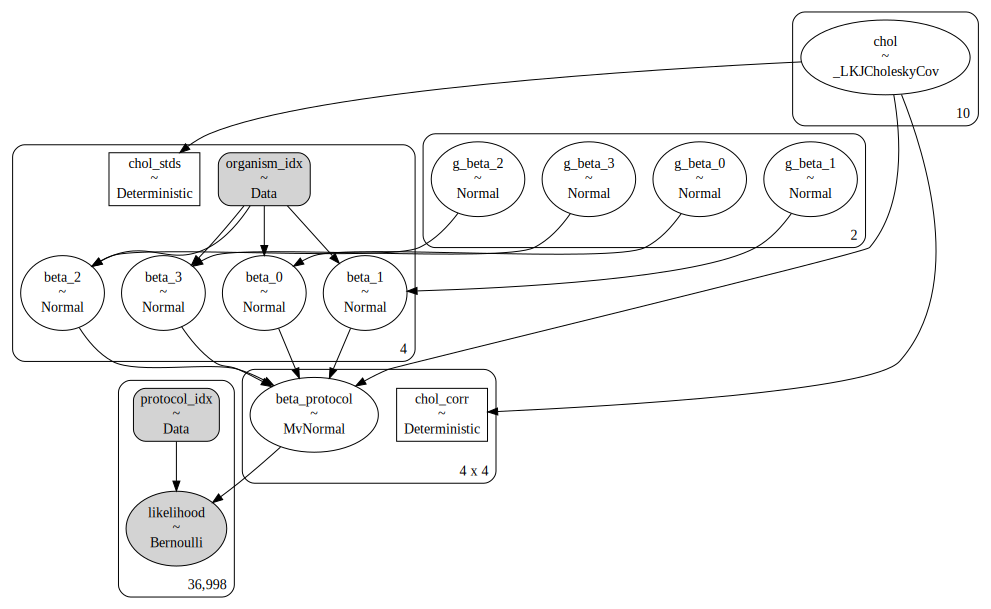

In [208]:
pm.model_to_graphviz(assay_level_model)

In [ ]:
with assay_level_model:
    tr_assay = pm.sample(500, tune=500, init="adapt_diag",chains=4,cores=8)


In [ ]:
with assay_level_model:
    az.plot_forest(
        tr_assay,
        combined=True,
        var_names=["beta_protocol"],
        figsize=(10, 10),
        textsize=14,
    )